In [1]:
import numpy as np
import scipy.stats as ss
import elfi
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.examples import clinic
from pyabc.utils import plot_marginals

warning in stationary: failed to import cython module: falling back to numpy


# Clinic Example
![](img/clinic.png)

In [2]:
simulator = clinic.simulator

In [3]:
# Set the generating parameters that we will try to infer
lambda0 = 1/10

# Generate some dat9 (using a fixed seed here)
np.random.seed(1228)
y0 = simulator(lambda0)
print(y0)

[[49], array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.42344354,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   4.51585521,   0.        ,
         4.34929369,   5.33611555,   4.79045358,  11.19269357,
        10.47966238,   6.52416327,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   5.97595535,   8.83547883,
         0.        ,   0.        ,   0.        ,   0.29101362,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,   0.        ]), [964.8378133280579]]


In [4]:
closing_time, nr_patients, nr_waiting_patients = clinic.summaries

In [5]:
# prior over rate parameter
rate = pyabc.Prior('uniform', 0.01,1, name='rate')
rate.name

'rate'

# Our PYABC

In [6]:
rej = pyabc.RejectionSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [7]:
rej.sample(nr_samples=1000, threshold=15)

Rejection sampler started with threshold: 15 and number of samples: 1000
Samples:   1000 - Threshold: 15.00 - Iterations:      21000 - Acceptance rate: 0.047619 - Time:    20.62 s


In [8]:
smc = pyabc.SMCSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [9]:
smc.sample(nr_samples=1000, thresholds=[30,20,10,5])

SMC sampler started with thresholds: [30, 20, 10, 5] and number of samples: 1000
Rejection sampler started with threshold: 30 and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
Samples:   1000 - Thresholds: 5.00 - Iterations:      43370 - Acceptance rate: 0.023057 - Time:    31.05 s


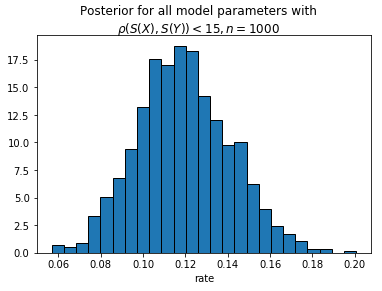

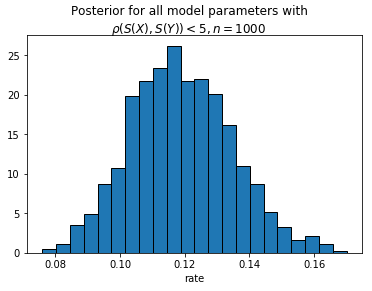

In [10]:
plot_marginals(rej)
plot_marginals(smc)

# ELFI

In [13]:
# Prior
elfi.new_model() # important to reset, otherwise rerun the code will produce two nodes for S1, S2 and so on
rate = elfi.Prior('uniform', 0.01, 1)

# Add the simulator node and observed data to the model
#vectorized_simulator = elfi.tools.vectorize(simulator)
sim = elfi.Simulator(simulator, rate, observed=y0)

# Add summary statistics to the model
#S1 = elfi.Summary(mean, sim, name="mean")
#S2 = elfi.Summary(var, sim, name="var")
S3 = elfi.Summary(closing_time, sim, name="closing time")
S4 = elfi.Summary(nr_patients, sim, name="total patients")
S5 = elfi.Summary(nr_waiting_patients, sim, name="nr of patients waiting")

d4 = elfi.Distance('euclidean', S3, S4, S5)

In [14]:
rej = elfi.Rejection(d4, batch_size=1)
res = rej.sample(1000, threshold=10)
print(res)

Method: Rejection
Number of samples: 1000
Number of simulations: 45876
Threshold: 10
Sample means: rate: 0.118



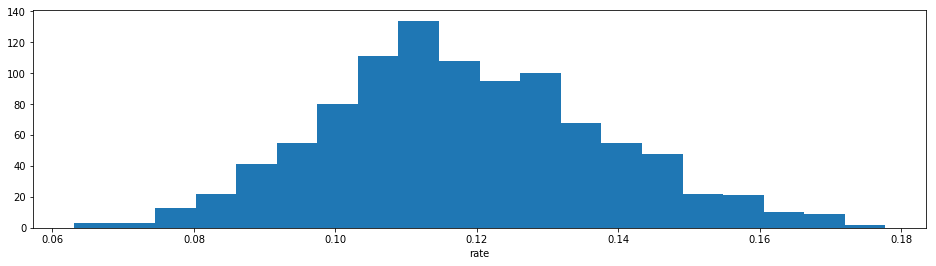

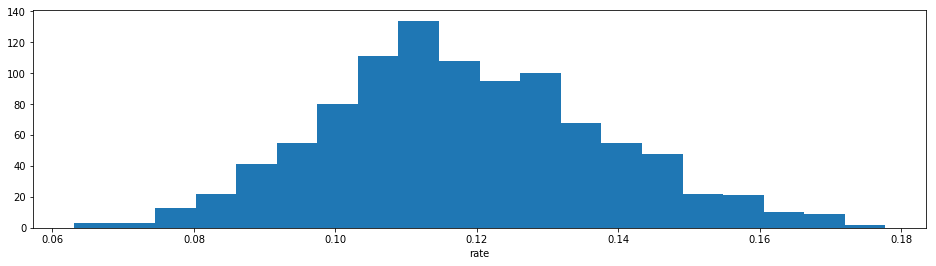

In [16]:
res.plot_marginals()
plt.show()